
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [56]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

In [57]:
df_heart = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
df_heart.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [58]:
X = df_heart.drop("cp", axis=1)
y = df_heart["cp"]

In [59]:
ct = ColumnTransformer(
    [
      ("dummify", 
      OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
      make_column_selector(dtype_include=object)),
      ("standardize", 
      StandardScaler(), 
      make_column_selector(dtype_include=np.number))
    ],
    remainder = "drop"
)

In [60]:
pipeline = Pipeline(
  [("selection", ct),
  ("kNN", KNeighborsClassifier(n_neighbors=5))]
).set_output(transform="pandas")

y_pred = cross_val_predict(pipeline, X, y, cv=5)
accuracy_score(y, y_pred)

0.45787545787545786

In [61]:
pipeline = Pipeline(
  [("selection", ct),
  ("lda", LinearDiscriminantAnalysis())]
).set_output(transform="pandas")

y_pred = cross_val_predict(pipeline, X, y, cv=5)
accuracy_score(y, y_pred)

0.5421245421245421

In [62]:
pipeline = Pipeline(
  [("preprocessing", ct),
  ("dec_tree", DecisionTreeClassifier())]
).set_output(transform="pandas")

y_pred = cross_val_predict(pipeline, X, y, cv=5)
accuracy_score(y, y_pred)

0.3882783882783883

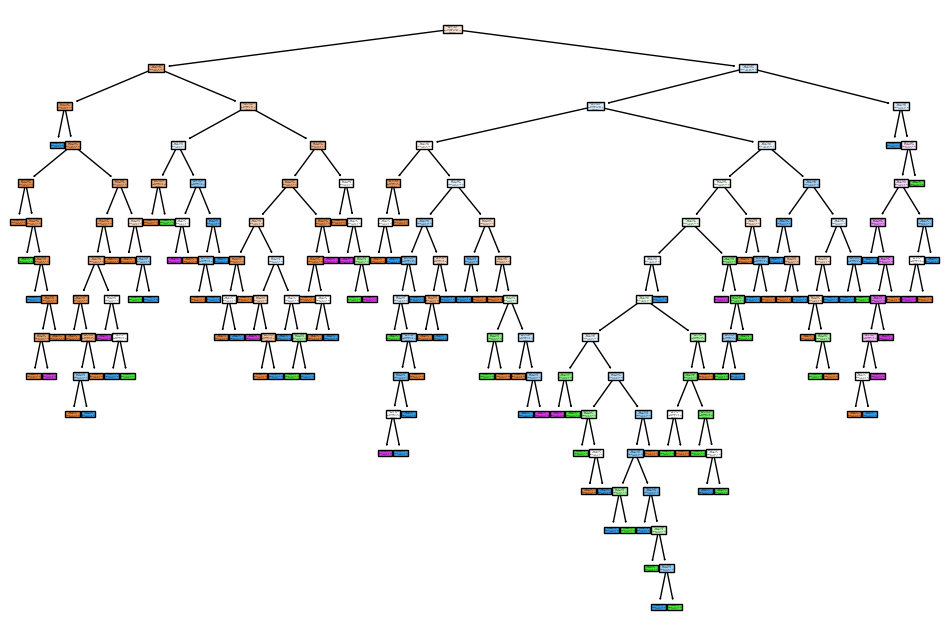

In [63]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

pipeline.fit(X, y)

plt.figure(figsize=(12, 8))
plot_tree(pipeline.named_steps["dec_tree"], filled=True, feature_names=X.columns, class_names=["0", "1", "2", "3"])
plt.show()

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [64]:
df_heart["cp_is_3"] = (df_heart["cp"] == 3).astype(int)

X = df_heart.drop(["cp", "cp_is_3"], axis=1)
y = df_heart["cp_is_3"]

from sklearn.model_selection import cross_val_score

pipeline = Pipeline(
  [("preprocessing", ct),
  ("logestic_regression", LogisticRegression())]
).set_output(transform="pandas")

cross_val_score(pipeline, X, y, cv=5, scoring='f1')

array([0., 0., 0., 0., 0.])

In [65]:
df_heart["cp_is_2"] = (df_heart["cp"] == 2).astype(int)

X = df_heart.drop(["cp", "cp_is_2"], axis=1)
y = df_heart["cp_is_2"]

from sklearn.model_selection import cross_val_score

pipeline = Pipeline(
  [("preprocessing", ct),
  ("logestic_regression", LogisticRegression())]
).set_output(transform="pandas")

cross_val_score(pipeline, X, y, cv=5, scoring='f1')

array([0.42105263, 0.38461538, 0.10526316, 0.        , 0.        ])

In [66]:
df_heart["cp_is_1"] = (df_heart["cp"] == 1).astype(int)

X = df_heart.drop(["cp", "cp_is_1"], axis=1)
y = df_heart["cp_is_1"]

from sklearn.model_selection import cross_val_score

pipeline = Pipeline(
  [("preprocessing", ct),
  ("logestic_regression", LogisticRegression())]
).set_output(transform="pandas")

cross_val_score(pipeline, X, y, cv=5, scoring='f1')

array([0.59259259, 0.59259259, 0.57142857, 0.66666667, 0.2       ])

In [67]:
df_heart["cp_is_0"] = (df_heart["cp"] == 0).astype(int)

X = df_heart.drop(["cp", "cp_is_0"], axis=1)
y = df_heart["cp_is_0"]

from sklearn.model_selection import cross_val_score

pipeline = Pipeline(
  [("preprocessing", ct),
  ("logestic_regression", LogisticRegression())]
).set_output(transform="pandas")

cross_val_score(pipeline, X, y, cv=5, scoring='f1')

array([1., 1., 1., 1., 1.])

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [82]:
df_chest = df_heart[(df_heart["cp"] == 0) | (df_heart["cp"] == 1)]
df_chest = df_chest.drop(["cp_is_3", "cp_is_2", "cp_is_1", "cp_is_0"], axis=1)

X = df_chest.drop("cp", axis=1)
y = df_chest["cp"]

from sklearn.model_selection import cross_val_score

ct = ColumnTransformer(
    [
      ("dummify", 
      OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
      make_column_selector(dtype_include=object)),
      ("standardize", 
      StandardScaler(), 
      make_column_selector(dtype_include=np.number))
    ],
    remainder = "drop"
)

pipeline = Pipeline(
  [("preprocessing", ct),
  ("logestic_regression", LogisticRegression())]
).set_output(transform="pandas")

cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc').mean()

0.8376709401709401

In [83]:
df_chest = df_heart[(df_heart["cp"] == 0) | (df_heart["cp"] == 2)]
df_chest = df_chest.drop(["cp_is_3", "cp_is_2", "cp_is_1", "cp_is_0"], axis=1)

X = df_chest.drop("cp", axis=1)
y = df_chest["cp"]

from sklearn.model_selection import cross_val_score

ct = ColumnTransformer(
    [
      ("dummify", 
      OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
      make_column_selector(dtype_include=object)),
      ("standardize", 
      StandardScaler(), 
      make_column_selector(dtype_include=np.number))
    ],
    remainder = "drop"
)

pipeline = Pipeline(
  [("preprocessing", ct),
  ("logestic_regression", LogisticRegression())]
).set_output(transform="pandas")

cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc').mean()

0.7515837104072398

In [84]:
df_chest = df_heart[(df_heart["cp"] == 0) | (df_heart["cp"] == 3)]
df_chest = df_chest.drop(["cp_is_3", "cp_is_2", "cp_is_1", "cp_is_0"], axis=1)

X = df_chest.drop("cp", axis=1)
y = df_chest["cp"]

from sklearn.model_selection import cross_val_score

ct = ColumnTransformer(
    [
      ("dummify", 
      OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
      make_column_selector(dtype_include=object)),
      ("standardize", 
      StandardScaler(), 
      make_column_selector(dtype_include=np.number))
    ],
    remainder = "drop"
)

pipeline = Pipeline(
  [("preprocessing", ct),
  ("logestic_regression", LogisticRegression())]
).set_output(transform="pandas")

cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc').mean()

0.7412307692307692